# Imports

In [0]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from scipy.ndimage import rotate

# Download data from Kaggle

In [0]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

    100% |████████████████████████████████| 61kB 4.0MB/s 
    100% |████████████████████████████████| 235kB 7.2MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [0]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
! KAGGLE_USERNAME="nellikh" KAGGLE_KEY="25987acf3481c85ed60ef8b53b43de3c" kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

100% 7.36G/7.37G [00:55<00:00, 163MB/s]
100% 7.37G/7.37G [00:55<00:00, 142MB/s]


In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [0]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

# Functions for augmentation

In [0]:
### Это функции для аугментации. 
### При их использовании BatchSize брался в 5 раз меньше, т.к. генератор делал в 5 раз больше картинок
### В итоге аугментацию было решено не использовать, т.к. простая модель, 
### обученная на разных картинках показывала результат лучше, чем та же модель,
### обученная на картинках, полученных при помощи аугментации - последние две посылки

def add_noise(img):# ADDING NOISE
  noise = np.random.randint(2, size = (64, 64), dtype = 'uint8')
  for i in range(500):
      x = np.random.randint(0, high=64)
      y = np.random.randint(0, high=64)
      img[x][y] += noise[x][y]
  return(img)


def shift_right(img):# Shifting Right
  for j in range(64):
    for i in range(64):
      if (i < 64-15):
        img[j][i] = img[j][i+15]
      else:
        img[j][i] = 255
  return(img)


def shift_down(img):#Shifting Down
  for j in range(63, 0, -1):
    for i in range(64):
      if (j < 64 and j > 15):
        img[j][i] = img[j-15][i]
      else:
        img[j][i] = 255
  return(img)

def random_rotating(img):#Random Rotating
  img = rotate(img, np.random.randint(30, high=330), reshape=False)
  return(img)

# Images generator

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw

IMG_SIZE = 64

# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256, 256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    return np.array(image, dtype=np.uint8)

# Augmentation check

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_images.append(add_noise(draw_it(e[0])))
            batch_images.append(shift_right(draw_it(e[0])))
            batch_images.append(shift_down(draw_it(e[0])))
            batch_images.append(random_rotating(draw_it(e[0])))
            for i in range(5):
              batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


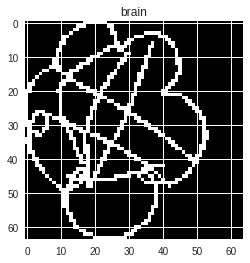

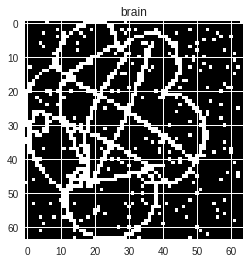

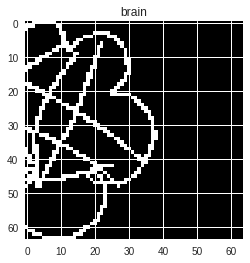

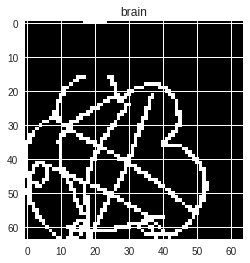

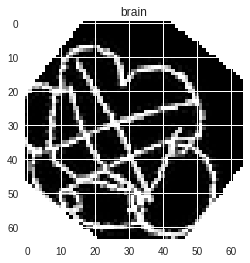

In [0]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][0, :, :])
plt.title(b[1][0])
plt.show()

plt.imshow(b[0][1, :, :])
plt.title(b[1][1])
plt.show()

plt.imshow(b[0][2, :, :])
plt.title(b[1][2])
plt.show()

plt.imshow(b[0][3, :, :])
plt.title(b[1][3])
plt.show()

plt.imshow(b[0][4, :, :])
plt.title(b[1][4])
plt.show()

# images_and_labels_generator no augmentation

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

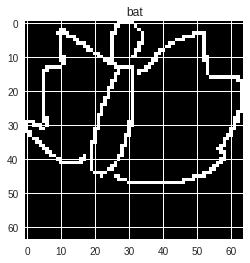

In [0]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][0, :, :])
plt.title(b[1][0])
plt.show()

# Train simple network

In [0]:
import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5### YOUR CODE HERE: normalize images!
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [0]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 64, 64, 1)
(32, 340)


In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, LeakyReLU

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    ### YOUR CODE HERE: replace with a better model! Batch normalization really helps!
    
    ### Эта модель дала 0.749 BATCH_SIZE = 1000 STEPS_PER_EPOCH = 50000000 // (BATCH_SIZE * 100) EPOCHS = 10
    """ 
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(680, activation='elu'))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    """
    ### Эта модель дала 0.797
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(LeakyReLU(alpha = 0.7))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha = 0.7))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha = 0.7))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha = 0.7))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    # С этой добавкой дало 0.808
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha = 0.7))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # Для проверки эффективности аугментации была взята простая модель
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(LeakyReLU(alpha = 0.7))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha = 0.7))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    """
    
    model.add(Flatten())
    model.add(Dense(680, activation='elu'))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [0]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 1000
STEPS_PER_EPOCH = 50000000 // (BATCH_SIZE * 100) # число объектов поделить на batchsize
EPOCHS = 10

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/10
500/500 [==============================] - 397s 793ms/step - loss: 2.2874 - categorical_accuracy: 0.4871 - top_3_accuracy: 0.6738
Model saved in model_0
Epoch 2/10
500/500 [==============================] - 394s 789ms/step - loss: 1.5830 - categorical_accuracy: 0.6216 - top_3_accuracy: 0.8028
Model saved in model_1
Epoch 3/10
500/500 [==============================] - 396s 792ms/step - loss: 1.4294 - categorical_accuracy: 0.6535 - top_3_accuracy: 0.8279
Model saved in model_2
Epoch 4/10
500/500 [==============================] - 394s 789ms/step - loss: 1.3398 - categorical_accuracy: 0.6726 - top_3_accuracy: 0.8427
Model saved in model_3
Epoch 5/10
500/500 [==============================] - 394s 788ms/step - loss: 1.2979 - categorical_accuracy: 0.6820 - top_3_accuracy: 0.8494
Model saved in model_4
Epoch 6/10
500/500 [==============================] - 391s 783ms/step - loss: 1.2535 - categorical_accuracy: 0.6912 - top_3_accuracy: 0.8560
Model saved in model_5
Epoch 7/10
500/5

# Score test set

In [0]:
# download test set
! KAGGLE_USERNAME="nellikh" KAGGLE_KEY="25987acf3481c85ed60ef8b53b43de3c" kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

test_simplified.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                batch_images = batch_images / 255 - 0.5### YOUR CODE HERE: normalize batch_images the same way as during training!
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            batch_images = batch_images / 255 - 0.5### YOUR CODE HERE: normalize batch_images the same way as during training!
            yield batch_keys, batch_images

In [0]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [0]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

100%|██████████| 113/113.0 [01:39<00:00,  1.32it/s]


In [0]:
! wc -l submission.csv

112200 submission.csv


In [0]:
# submit to kaggle
! KAGGLE_USERNAME="nellikh" KAGGLE_KEY="25987acf3481c85ed60ef8b53b43de3c" kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.43M/4.43M [00:04<00:00, 1.04MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge